Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Simplisma code

In [2]:
def simplisma(d, nr, error):

	def wmat(c,imp,irank,jvar):
		dm=np.zeros((irank+1, irank+1))
		dm[0,0]=c[jvar,jvar]
		
		for k in range(irank):
			kvar=int(imp[k])
			
			dm[0,k+1]=c[jvar,kvar]
			dm[k+1,0]=c[kvar,jvar]
			
			for kk in range(irank):
				kkvar=int(imp[kk])
				dm[k+1,kk+1]=c[kvar,kkvar]
		
		return dm

	nrow,ncol=d.shape
	
	dl = np.zeros((nrow, ncol))
	imp = np.zeros(nr)
	mp = np.zeros(nr)
	
	w = np.zeros((nr, ncol))
	p = np.zeros((nr, ncol))
	s = np.zeros((nr, ncol))
	
	error=error/100
	mean=np.mean(d, axis=0)
	error=np.max(mean)*error
	
	s[0,:]=np.std(d, axis=0)
	w[0,:]=(s[0,:]**2)+(mean**2)
	p[0,:]=s[0,:]/(mean+error)

	imp[0] = int(np.argmax(p[0,:]))
	mp[0] = p[0,:][int(imp[0])]
	
	l=np.sqrt((s[0,:]**2)+((mean+error)**2))

	for j in range(ncol):
		dl[:,j]=d[:,j]/l[j]
		
	c=np.dot(dl.T,dl)/nrow
	
	w[0,:]=w[0,:]/(l**2)
	p[0,:]=w[0,:]*p[0,:]
	s[0,:]=w[0,:]*s[0,:]

	for i in range(nr-1):
		for j in range(ncol):
			dm=wmat(c,imp,i+1,j)
			w[i+1,j]=np.linalg.det(dm)
			p[i+1,j]=w[i+1,j]*p[0,j]
			s[i+1,j]=w[i+1,j]*s[0,j]
			
		imp[i+1] = int(np.argmax(p[i+1,:]))
		mp[i+1] = p[i+1,int(imp[i+1])]
		
	sp=np.zeros((nrow, nr))
			
	for i in range(nr):
		sp[0:nrow,i]=d[0:nrow,int(imp[i])]
	
	concs = np.dot(np.linalg.pinv(sp), d)
	
	return sp, concs

Import data

In [3]:
file_path = 'Ti.dat'

# Load the matrix from the file
matrix = np.loadtxt(file_path)

E = matrix.T[0]
D = matrix.T[13:-8]
print(D.shape)

(10, 142)


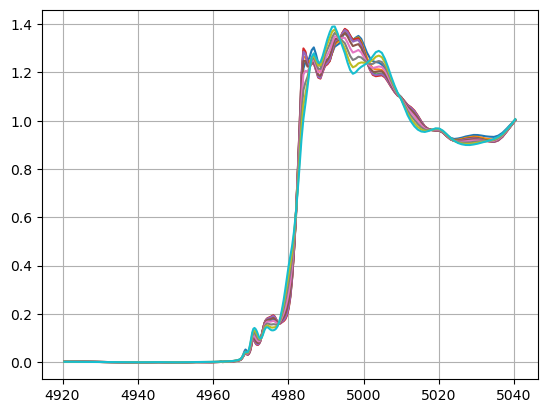

In [4]:
fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()


ax.plot(E, D.T)

ax.grid('True')

Define number of components

In [5]:
n_comp = 3

Simplisma and plot results

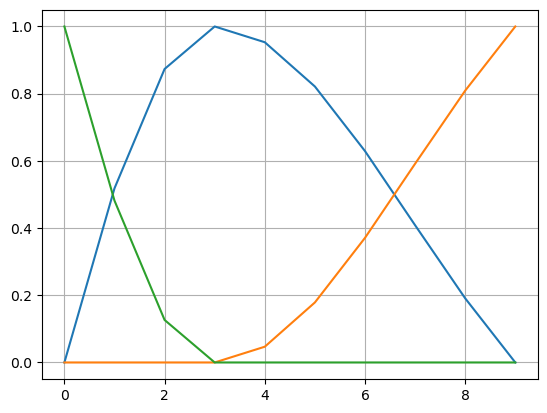

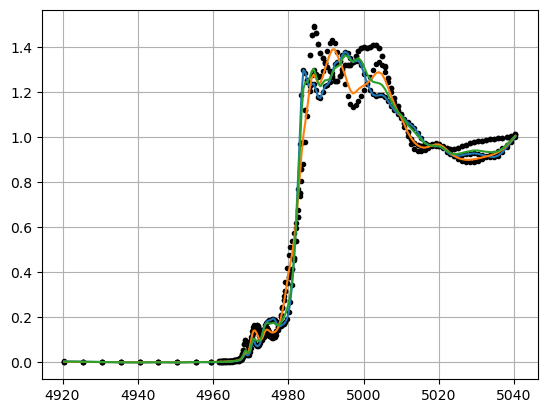

In [6]:
sp, concs = simplisma(D.T, n_comp, 5)

fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

ax.plot([x for x in range(0, len(concs.T))], concs.T)

# Add legend and grid
# ax.legend()
ax.grid('True')

fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

ax.plot(E, matrix.T[1], 'k.')
ax.plot(E, matrix.T[2], 'k.')
ax.plot(E, matrix.T[16], 'k.')
ax.plot(E, matrix.T[30], 'k.')

# ax.plot(E, matrix[1], 'k.')
# ax.plot(E, matrix[2], 'k.')
# ax.plot(E, matrix[3], 'k.')
# ax.plot(E, matrix[4], 'k.')

ax.plot(E, sp)

# Add legend and grid
# ax.legend()
ax.grid('True')

ONCA - Objective-based Numerical Component Analysis

Code to make upper and lower matrices

In [7]:
def matrices(delta, n_comp):
    l_matrix = [- delta] * (n_comp * (n_comp - 1))
    for i in range(n_comp - 1):
        l_matrix[i * (n_comp + 1)] = 1 - delta
    
    u_matrix = [delta] * (n_comp * (n_comp - 1))
    for i in range(n_comp - 1):
        u_matrix[i * (n_comp + 1)] = 1 + delta
        
    return l_matrix, u_matrix

In [8]:
max_sp = 0
min_sp = 1000
for a in range(n_comp):
    w = max(sp.T[a])
    m = min(sp.T[a])
    if w > max_sp:
        max_sp = w
    if m < min_sp:
        min_sp = m

Define the problem

In [9]:
class ProblemWrapper(Problem):

    def _evaluate(self, designs, out, *args, **kwargs):
        x = []
        g = []
        
        for m in designs:
            t1 = []
            ini = 0
            for n in range(ini, n_comp * (n_comp - 1), (n_comp)):
                temp = []
                for i in range(n_comp):
                    temp.append(m[n + i])
                t1.append(temp)
            
            new_concs = t1 @ concs
            temp = []
            new_concs = np.maximum(new_concs, 0)
            new_concs_T = new_concs.T
            for i in range(len(new_concs_T)):
                array_sum = np.sum(new_concs.T[i])
                if array_sum > 1:
                    new_concs_T[i] = new_concs_T[i] / array_sum
                    temp.append(0)
                else:
                    temp.append(1 - array_sum)
                    
            new_concs = new_concs_T.T
            new_concs = np.vstack((new_concs, np.array(temp)))
            new_concs = np.maximum(new_concs, - new_concs)
            sp_concs = sp@concs
            a, residuals, rank, s_parameter = np.linalg.lstsq(sp, sp_concs, rcond = None)
            t1_, residuals, rank, s_parameter = np.linalg.lstsq(new_concs.T, a.T, rcond = None)
            t1_ = t1_.T
            new_sp = sp @ t1_
            amp = 0
            neg = 0
            zer = 0
            for a in range(n_comp):
                if max(new_sp.T[a]) > 1.1 * max_sp:
                    amp += max(new_sp.T[a]) - 1.1 * max_sp
                if min(new_sp.T[a]) < 1.00 * min_sp:
                    neg += np.abs(min(new_sp.T[a]))
                if max(new_concs.T[a]) < 0.50:
                    zer += 1 - max(new_concs.T[a])
            g.append([neg/n_comp, amp/n_comp, zer/n_comp])
#             g.append([neg/n_comp, amp/n_comp])
            res = new_sp @ new_concs - D.T
            sst1 = sum(np.sum(res ** 2, axis=0))
            sst2 = sum(np.sum(D.T ** 2, axis=0))
            dn = np.copy(D.T)
            resn = dn - sp_concs
            un = sum(np.sum(resn ** 2, axis = 0))
            sstn = sum(np.sum(dn ** 2, axis = 0, dtype = np.float64))
            r2opt = (sstn - un)/sstn
            sigma = (np.sqrt(sst1 / sst2)) * 100
            
            x.append([1 - r2opt, sigma, np.abs(np.sum(res))])
    
        out["F"] = np.array(x)
        out["G"] = np.array(g)

Variables

In [10]:
# number of generations
n_gen = 10000

# population size
pop_size  = 25000

# max percentage deviation from simplisma answer
delta = 1.5

In [11]:
l_matrix, u_matrix = matrices(delta, n_comp)

n_var = n_comp * (n_comp - 1)
problem = ProblemWrapper(n_var = n_var, n_obj = 3, n_ieq_constr = 3, xl = l_matrix, xu = u_matrix)
algorithm = NSGA2(pop_size = pop_size)
# stop_criteria = ('n_gen', n_gen)
stop_criteria = get_termination("time", "00:30:00")

results = minimize( problem=problem,
                    algorithm=algorithm, 
                    termination=stop_criteria)

In [106]:
print(results.F[:5])
print('-------')
print(results.G[:5])
print('-------')
print(results.X[:5])
print('-------')
m = results.X[12]
ini = 0
t1 = []
for n in range(ini, n_comp * (n_comp - 1), (n_comp)):
    temp = []
    for i in range(n_comp):
        temp.append(m[n + i])
    t1.append(temp)
print(np.array(t1))
print('-------')
new_concs = t1 @ concs
temp = []
new_concs = np.maximum(new_concs, 0)
new_concs_T = new_concs.T
for i in range(len(new_concs_T)):
    array_sum = np.sum(new_concs.T[i])
    if array_sum > 1:
        new_concs_T[i] = new_concs_T[i] / array_sum
        temp.append(0)
    else:
        temp.append(1 - array_sum)

new_concs = new_concs_T.T
new_concs = np.vstack((new_concs, np.array(temp)))
new_concs = np.maximum(new_concs, - new_concs)
# print('-------')
print(new_concs.T)

[[1.31759048e-11 8.57577745e-01 9.97959448e-05]
 [1.31759048e-11 5.14741614e-01 9.97959452e-05]
 [1.31759048e-11 8.30036987e-01 9.97959449e-05]
 [1.31759048e-11 6.14293650e-01 9.97959452e-05]
 [1.31759048e-11 8.76155709e-01 9.97959447e-05]]
-------
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-------
[[ 1.89069595 -1.19679172  1.23952766 -0.92209524 -0.21642408  1.408277  ]
 [ 1.77737412 -0.45592817 -0.21330623 -0.34193786  2.09092302 -1.08505123]
 [ 1.52181665 -1.00368068  0.35289616 -0.15312354  1.88436153 -0.42590323]
 [ 1.63674498 -0.47130882  0.10013208 -0.57230461  2.08860588 -0.546741  ]
 [ 1.66889956 -1.2492409   0.17341713 -0.08488928  2.02557914 -1.44616514]]
-------
[[-0.01199316  0.14879919  1.12855884]
 [-0.00174764  0.70665486 -0.33832989]]
-------
[[ 1.         -0.         -0.        ]
 [ 0.53736353 -0.          0.46263647]
 [ 0.13229391 -0.          0.86770609]
 [-0.         -0.          1.        ]
 [-0.          0.0314939   0.9685061 ]
 [ 0.01671865  0

In [107]:
t1 = []
ini = 0
for n in range(ini, n_comp * (n_comp - 1), (n_comp)):
    temp = []
    for i in range(n_comp):
        temp.append(m[n + i])
    t1.append(temp)

new_concs = t1 @ concs
temp = []
new_concs = np.maximum(new_concs, 0)
new_concs_T = new_concs.T
for i in range(len(new_concs_T)):
    array_sum = np.sum(new_concs.T[i])
    if array_sum > 1:
        new_concs_T[i] = new_concs_T[i] / array_sum
        temp.append(0)
    else:
        temp.append(1 - array_sum)

new_concs = new_concs_T.T
new_concs = np.vstack((new_concs, np.array(temp)))
new_concs = np.maximum(new_concs, 0)

sp_new, residuals, rank, s_parameter = np.linalg.lstsq(new_concs.T, (sp @ concs).T, rcond = None)
sp_new = sp_new.T

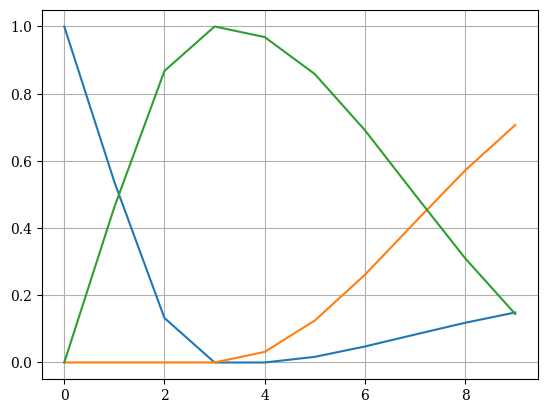

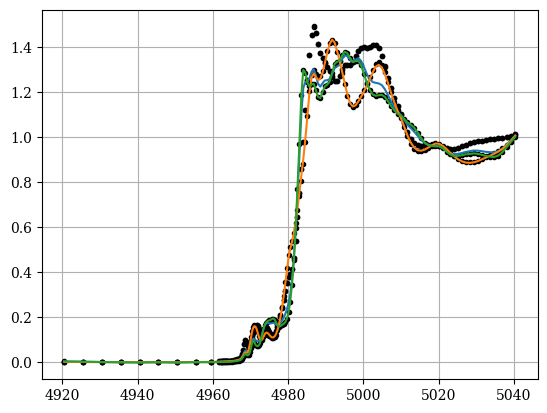

In [108]:
fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

ax.plot([x for x in range(0, len(new_concs.T))], new_concs.T)
# ax.plot([x for x in range(0, len(new_concs.T))], new_concs[0])
# ax.plot([x for x in range(0, len(new_concs.T))], new_concs[1])
# ax.plot([x for x in range(0, len(new_concs.T))], new_concs[2])
# ax.plot([x for x in range(0, len(new_concs.T))], new_concs[3])

ax.grid('True')

fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

ax.plot(E, matrix.T[1], 'k.')
ax.plot(E, matrix.T[2], 'k.')
ax.plot(E, matrix.T[16], 'k.')
ax.plot(E, matrix.T[30], 'k.')

# ax.plot(E, matrix[1], 'k.')
# ax.plot(E, matrix[2], 'k.')
# ax.plot(E, matrix[3], 'k.')
# ax.plot(E, matrix[4], 'k.')

ax.plot(E, sp_new)
# ax.plot(E, sp_new.T[0])
# ax.plot(E, sp_new.T[1])
# ax.plot(E, sp_new.T[2])
# ax.plot(E, sp_new.T[3])

ax.grid('True')

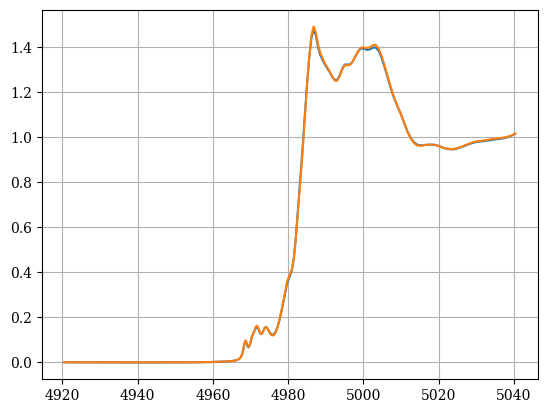

In [109]:
fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

# qqqq = []
# for i in range(sp_new.T[0]):
# q = np.array(matrix.T[1]) * 0.2665 + 0.7335 * np.array(matrix.T[16])
q = (sp_new.T[0] - 0.7335 * np.array(sp_new.T[2])) / 0.2665

ax.plot(E, q)
# ax.plot(E, sp_new.T[0])
ax.plot(E, matrix.T[1])


ax.grid('True')

In [111]:
interesse, residuals, rank, s_parameter = np.linalg.lstsq(sp, sp_new, rcond = None)
print(interesse)
posto = np.linalg.matrix_rank(interesse)
print(posto)

[[ 2.36648324e-02 -2.16764455e-01  1.00002194e+00]
 [-3.63335386e-04  1.41558707e+00  1.23389497e-03]
 [ 9.76698607e-01 -1.98822492e-01 -1.25510035e-03]]
3


In [ ]:
fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

ax.plot(E, matrix.T[1], 'k.')
ax.plot(E, matrix.T[2], 'k.')
ax.plot(E, matrix.T[16], 'k.')
ax.plot(E, matrix.T[30], 'k.')

# ax.plot(E, matrix[1], 'k.')
# ax.plot(E, matrix[2], 'k.')
# ax.plot(E, matrix[3], 'k.')
# ax.plot(E, matrix[4], 'k.')

ax.plot(E, sp_new)
# ax.plot(E, sp_new.T[0])
# ax.plot(E, sp_new.T[1])
# ax.plot(E, sp_new.T[2])
# ax.plot(E, sp_new.T[3])

ax.grid('True')

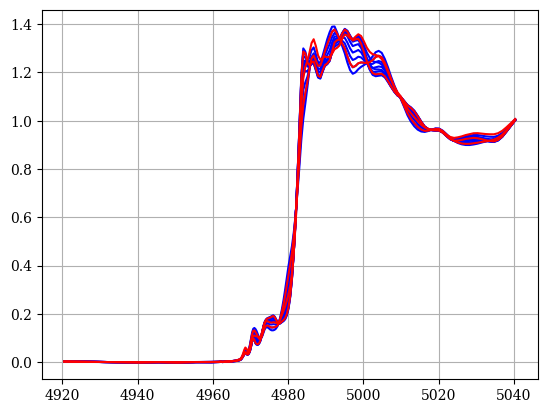

In [81]:
fig = plt.figure()

# Get the current axes or create new ones if none exist
ax = fig.gca()

ax.plot(E, D.T, c = 'b')
ax.plot(E, sp_new, c = 'r')

# ax.plot(E, sp_new.T[0], c = 'r')
# ax.plot(E, sp_new.T[1], c = 'r')
# ax.plot(E, sp_new.T[2], c = 'r')
# ax.plot(E, sp_new.T[3], c = 'r')

# Add legend and grid
# ax.legend()
ax.grid('True')

# Add legend and grid
# ax.legend()
ax.grid('True')

In [58]:
for a in range(n_comp):
#     print(max(sp_new[a]))
    print(max_sp)
    if max(sp_new.T[a]) > 1.2 * max_sp:
        print('A')

1.39045
1.39045
1.39045


In [59]:
sp_new.T[1]

array([ 1.91876545e-03,  1.10452067e-03,  2.79384259e-04, -4.83334784e-04,
       -9.74720380e-04, -3.37174232e-04, -8.54259651e-04,  2.75505301e-04,
        4.80304917e-04,  1.45380223e-03,  2.23656031e-03,  1.88789751e-03,
        1.68538648e-03,  2.18803786e-03,  2.25236396e-03,  2.39755224e-03,
        2.98007507e-03,  3.03354421e-03,  3.06082715e-03,  4.38938396e-03,
        3.74898399e-03,  4.84028070e-03,  5.60285583e-03,  6.21623204e-03,
        7.14615086e-03,  8.75715611e-03,  1.02170777e-02,  1.25709043e-02,
        1.67910372e-02,  2.45880550e-02,  3.79672589e-02,  5.48705486e-02,
        6.60187365e-02,  6.06031769e-02,  5.02085771e-02,  4.92974705e-02,
        5.88412290e-02,  7.80827153e-02,  9.83288576e-02,  1.09355074e-01,
        1.10895450e-01,  1.10732797e-01,  1.12574504e-01,  1.10966255e-01,
        1.07927415e-01,  1.07273673e-01,  1.14136956e-01,  1.28855065e-01,
        1.46017647e-01,  1.60194363e-01,  1.67454306e-01,  1.69447911e-01,
        1.67228511e-01,  

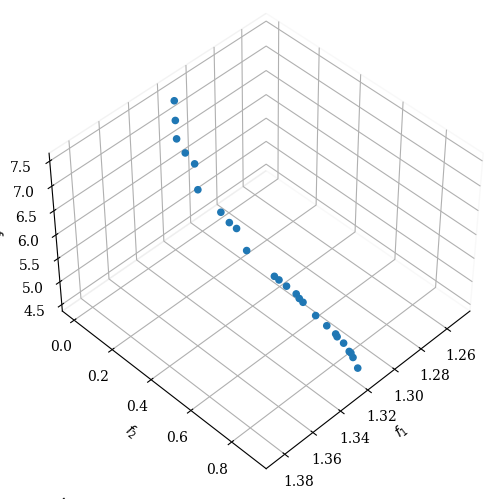

In [60]:
from pymoo.visualization.scatter import Scatter
Scatter().add(results.F).show()

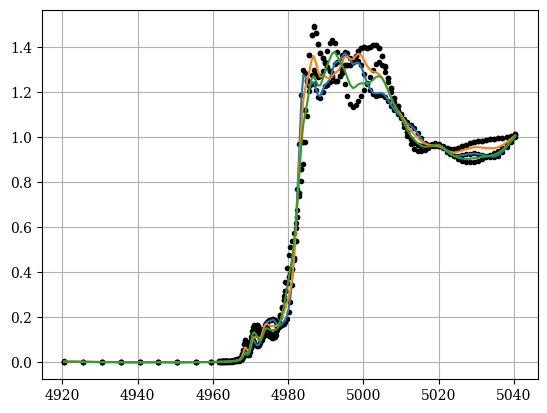

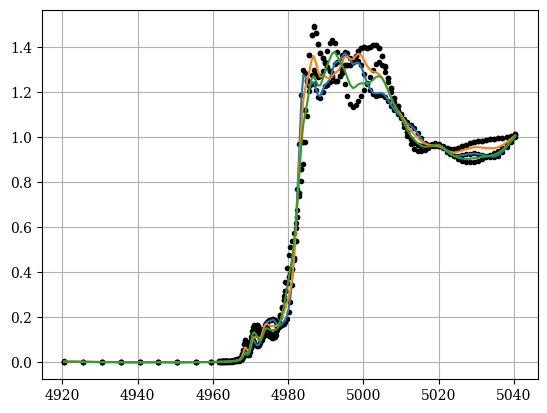

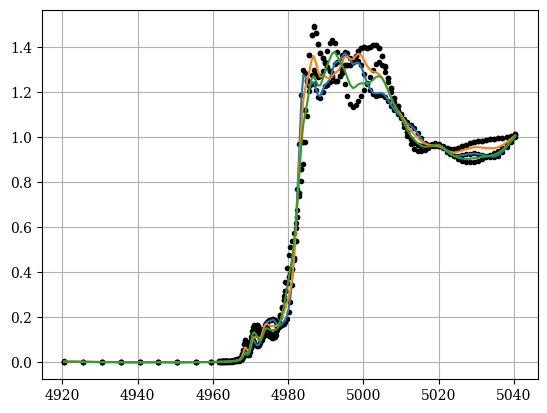

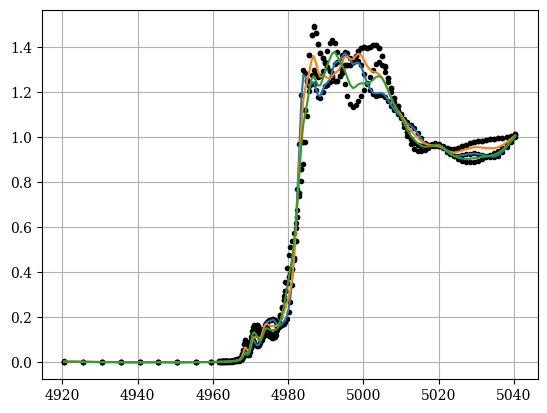

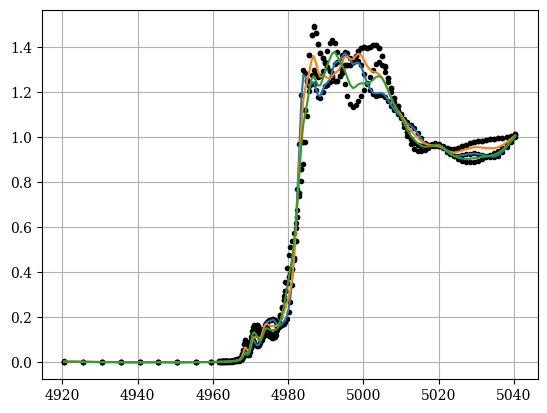

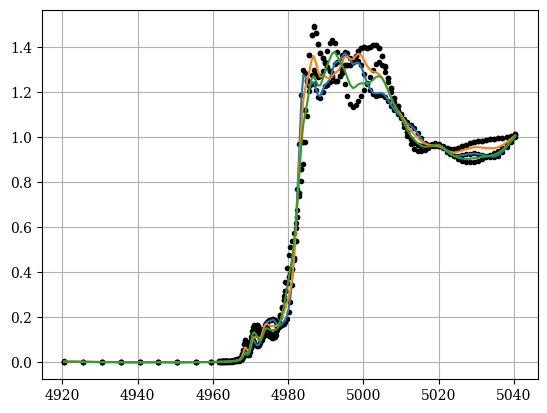

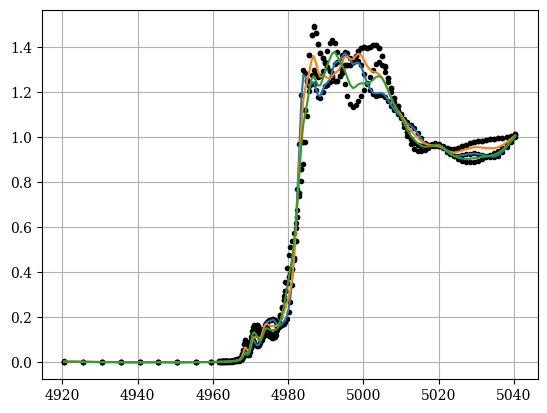

In [73]:
for w in range(0, len(results.X), 4):
    m = results.X[w]


    ini = 0
    t1 = []
    for n in range(ini, n_comp * (n_comp - 1), (n_comp)):
        temp = []
        for i in range(n_comp):
            temp.append(m[n + i])
        t1.append(temp)
    new_concs = t1 @ concs
    temp = []
    new_concs = np.maximum(new_concs, 0)
    new_concs_T = new_concs.T
    for i in range(len(new_concs_T)):
        array_sum = np.sum(new_concs.T[i])
        if array_sum > 1:
            new_concs_T[i] = new_concs_T[i] / array_sum
            temp.append(0)
        else:
            temp.append(1 - array_sum)

    new_concs = new_concs_T.T
    new_concs = np.vstack((new_concs, np.array(temp)))
    new_concs = np.maximum(new_concs, - new_concs)


#     fig = plt.figure()

#     # Get the current axes or create new ones if none exist
#     ax = fig.gca()

#     ax.plot([x for x in range(0, len(new_concs.T))], new_concs.T)
#     # ax.plot([x for x in range(0, len(new_concs.T))], new_concs[0])
#     # ax.plot([x for x in range(0, len(new_concs.T))], new_concs[1])
#     # ax.plot([x for x in range(0, len(new_concs.T))], new_concs[2])
#     # ax.plot([x for x in range(0, len(new_concs.T))], new_concs[3])

#     ax.grid('True')

    fig = plt.figure()

    # Get the current axes or create new ones if none exist
    ax = fig.gca()

    ax.plot(E, matrix.T[1], 'k.')
    ax.plot(E, matrix.T[2], 'k.')
    ax.plot(E, matrix.T[16], 'k.')
    ax.plot(E, matrix.T[30], 'k.')

    # ax.plot(E, matrix[1], 'k.')
    # ax.plot(E, matrix[2], 'k.')
    # ax.plot(E, matrix[3], 'k.')
    # ax.plot(E, matrix[4], 'k.')

    ax.plot(E, sp_new)
    # ax.plot(E, sp_new.T[0])
    # ax.plot(E, sp_new.T[1])
    # ax.plot(E, sp_new.T[2])
    # ax.plot(E, sp_new.T[3])
    
    ax.title(w)
    ax.grid('True')


#     fig = plt.figure()

#     # Get the current axes or create new ones if none exist
#     ax = fig.gca()

#     ax.plot(E, D.T, c = 'b')
#     ax.plot(E, sp_new, c = 'r')

#     # ax.plot(E, sp_new.T[0], c = 'r')
#     # ax.plot(E, sp_new.T[1], c = 'r')
#     # ax.plot(E, sp_new.T[2], c = 'r')
#     # ax.plot(E, sp_new.T[3], c = 'r')

#     # Add legend and grid
#     # ax.legend()
#     ax.grid('True')